In [1]:
import gym
import gym_anytrading
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import yfinance as yf
df = yf.download('MSFT', period='1y', interval='1h')

[*********************100%***********************]  1 of 1 completed


In [3]:
df.dtypes

Price      Ticker
Adj Close  MSFT      float64
Close      MSFT      float64
High       MSFT      float64
Low        MSFT      float64
Open       MSFT      float64
Volume     MSFT        int64
dtype: object

In [4]:
df['Volume'] = df['Volume'].astype('float64')


In [5]:
df.describe()


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
count,1756.000000,1756.000000,1756.000000,1756.000000,1756.000000,1.756000e+03
mean,418.751212,418.751212,419.895242,417.526751,418.749600,2.112906e+06
std,18.930503,18.930503,18.946737,18.879829,18.921088,1.505216e+06
min,367.000000,367.000000,368.019989,366.500000,367.005005,0.000000e+00
25%,408.104988,408.104988,409.489334,406.919998,408.147499,1.228848e+06
50%,417.863297,417.863297,419.135010,416.647507,418.014999,1.674428e+06
75%,428.649925,428.649925,429.757500,427.730011,428.585007,2.486460e+06
max,467.829987,467.829987,468.350006,466.989990,467.825012,1.645613e+07


<Axes: xlabel='Datetime'>

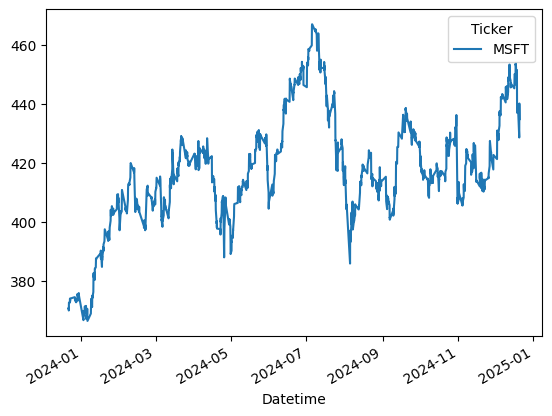

In [6]:
df.plot(y='Low', use_index=True)


In [7]:
# Create the environment
from gym_anytrading.envs import StocksEnv

In [8]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT,MSFT
Datetime,,,,,,
2023-12-21 14:30:00+00:00,371.489990,371.489990,374.410004,370.820007,372.559998,3992502.0
2023-12-21 15:30:00+00:00,371.600006,371.600006,372.390015,370.989990,371.549988,1467767.0
2023-12-21 16:30:00+00:00,370.549988,370.549988,371.950012,370.040009,371.595001,1655961.0
2023-12-21 17:30:00+00:00,371.010010,371.010010,371.200012,370.070099,370.519989,1506542.0
2023-12-21 18:30:00+00:00,371.869995,371.869995,372.070007,370.690002,371.070007,1300448.0
...,...,...,...,...,...,...
2024-12-20 16:30:00+00:00,443.350006,443.350006,443.720306,440.140015,440.230011,2235085.0
2024-12-20 17:30:00+00:00,439.559998,439.559998,443.464996,439.480011,443.390015,2122624.0


In [23]:
from keras.layers import *
from keras.models import Sequential
import tensorflow as tf
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch
import torch.nn as nn

In [90]:
from keras.layers import *
from keras.regularizers import l1_l2
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
class FlattenFeatureExtractor(BaseFeaturesExtractor):
    """Custom feature extractor that flattens the input"""
    
    def __init__(self, observation_space):
        # Must call super().__init__ first to set up proper inheritance
        feature_dim = int(np.prod(observation_space.shape))
        super().__init__(observation_space, features_dim=feature_dim)
        
        # Define the feature extraction layers
        self.flatten = nn.Flatten()
    
    def forward(self, observations):
        return self.flatten(observations)

class KerasActorCriticPolicy(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule, *args, **kwargs):
        # Initialize with our custom feature extractor
        super(KerasActorCriticPolicy, self).__init__(
            observation_space,
            action_space,
            lr_schedule,
            features_extractor_class=FlattenFeatureExtractor,
            features_extractor_kwargs={},  # No additional kwargs needed
            *args,
            **kwargs
        )
        
        # Create Keras model
        self.keras_model = Sequential([
                # Reshape layer to match input
            Reshape(observation_space.shape),  
            BatchNormalization(),

            Conv1D(32, kernel_size=3),
            PReLU(),
            BatchNormalization(),

            
            SpatialDropout1D(0.1),

            Conv1D(32, kernel_size=3),
            BatchNormalization(),
            PReLU(),
            
            SpatialDropout1D(0.1),

            LSTM(32, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
            BatchNormalization(),
            GlobalMaxPooling1D(),
            BatchNormalization(),
            Dense(units=64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            
            Dropout(0.1),
            Dense(units=3, activation='linear')
        ])
        self.keras_model.build(input_shape=(1, observation_space.shape[0], observation_space.shape[1]))
        self.keras_model.summary()


In [91]:
# class EnhancedKerasActorCriticPolicy(ActorCriticPolicy):
#     def __init__(self, observation_space, action_space, lr_schedule, *args, **kwargs):
#         super(EnhancedKerasActorCriticPolicy, self).__init__(
#             observation_space,
#             action_space,
#             lr_schedule,
#             features_extractor_class=FlattenFeatureExtractor,
#             features_extractor_kwargs={},
#             *args,
#             **kwargs
#         )
#         print('OBS SPACE SHAPE:',observation_space.shape)
#         # Enhanced CNN + LSTM Architecture
#         self.keras_model = Sequential([
#             # Multi-timeframe input handling
#             Reshape(observation_space.shape),
            
#             # Enhanced CNN layers with residual connections
#             Conv1D(64, kernel_size=3, padding='same'),
#             BatchNormalization(),
#             PReLU(),
#             SpatialDropout1D(0.2),
            
#             Conv1D(64, kernel_size=5, padding='same'),
#             BatchNormalization(),
#             PReLU(),
#             SpatialDropout1D(0.2),
            
#             Conv1D(128, kernel_size=7, padding='same'),
#             BatchNormalization(),
#             PReLU(),
#             SpatialDropout1D(0.3),
            
#             # Dilated convolutions
#             Conv1D(128, kernel_size=3, dilation_rate=2, padding='same'),
#             BatchNormalization(),
#             PReLU(),
#             SpatialDropout1D(0.3),
            
#             # Bidirectional LSTM layers with attention
#             Bidirectional(LSTM(64, return_sequences=True,
#                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))),
#             BatchNormalization(),
            
#             Bidirectional(LSTM(64, return_sequences=True,
#                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01))),
#             BatchNormalization(),
            
#             # Attention mechanism
#             MultiHeadAttention(num_heads=4, key_dim=32),
            
#             # Global pooling and dense layers
#             GlobalAveragePooling1D(),
#             Dense(128, activation='relu',
#                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
#             BatchNormalization(),
#             Dropout(0.3),
            
#             Dense(64, activation='relu',
#                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
#             BatchNormalization(),
#             Dropout(0.3)
#         ])

# # Residual block implementation
# class ResidualBlock(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.conv1 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm1d(channels)
#         self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm1d(channels)
        
#     def forward(self, x):
#         residual = x
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += residual
#         return F.relu(out)

In [92]:
#Quant Finance
from finta import TA
import quantstats as qs

In [93]:
df.columns = df.columns.get_level_values(0)  # Get just the Price level names

df['return'] = np.log(df['Close'] / df['Close'].shift(1))
#Create columns for technical indicators & add them to the dataframe

df['RSI'] = TA.RSI(df,16)
df['SMA'] = TA.SMA(df, 20)
df['SMA_L'] = TA.SMA(df, 41)
df['OBV'] = TA.OBV(df)
#data['VWAP'] = TA.VWAP(data)
df['EMA'] = TA.EMA(df)
df['ATR'] = TA.ATR(df)
df.fillna(0, inplace=True)
#Add momentum, volatitlity, & distance to the data_frame
df['momentum'] = df['return'].rolling(5).mean().shift(1)
df['volatility'] = df['return'].rolling(20).std().shift(1)
df['distance'] = (df['Close'] - df['Close'].rolling(50).mean()).shift(1)
#Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  df[col] = df['Close'].shift(lag)
  cols.append(col)

df.dropna(inplace=True)

reg = np.linalg.lstsq(df[cols], df['Close'], rcond=None)[0]
df['Prediction'] = np.dot(df[cols], reg)

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [94]:
df

Price,Adj Close,Close,High,Low,Open,Volume,return,RSI,SMA,SMA_L,...,lag_5,Prediction,market_hours,pre_market,after_hours,Volume_SMA,Volume_ratio,Price_Volume_Corr,Close_zscore,Volume_zscore
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-16 18:30:00+00:00,0.228821,0.228821,0.181232,0.211873,0.207649,2747294.0,0.125812,46.932854,0.217721,0.274354,...,0.221183,0.201369,0,0,1,2.569093e+06,1.069364,-0.245877,0.782085,0.118489
2024-02-16 19:30:00+00:00,0.192922,0.192922,0.179753,0.201559,0.234572,1249763.0,-0.170652,39.320200,0.216371,0.271336,...,0.196868,0.228534,0,0,1,2.467365e+06,0.506517,-0.162058,-1.540709,-0.800142
2024-02-16 20:30:00+00:00,0.188212,0.188212,0.143721,0.190734,0.198674,2160162.0,-0.024717,38.447428,0.214570,0.266747,...,0.209610,0.192705,0,0,1,2.286112e+06,0.944906,-0.235083,-1.613981,-0.096410
2024-02-20 14:30:00+00:00,0.126599,0.141575,0.141436,0.152293,0.186034,7043973.0,-0.284738,31.145786,0.210558,0.260728,...,0.213799,0.188028,1,0,0,2.533607e+06,2.780216,-0.573822,-3.003727,2.680331
2024-02-20 15:30:00+00:00,0.160206,0.160206,0.110379,0.124146,0.147523,2402774.0,0.123630,36.300687,0.207210,0.255282,...,0.201770,0.142223,1,0,0,2.566996e+06,0.936026,-0.498715,-1.865958,-0.098179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20 16:30:00+00:00,0.688371,0.688371,0.668867,0.658084,0.651194,2235085.0,0.059037,47.726595,0.706115,0.738218,...,0.646362,0.648766,0,0,1,2.327612e+06,0.960248,-0.485340,-0.214166,-0.064180
2024-12-20 17:30:00+00:00,0.640125,0.640125,0.665434,0.649679,0.691137,2122624.0,-0.072665,42.143379,0.697096,0.734245,...,0.627713,0.687210,0,0,1,2.388107e+06,0.888831,-0.431542,-0.716697,-0.189079
2024-12-20 18:30:00+00:00,0.638279,0.638279,0.622614,0.633634,0.642598,1869323.0,-0.002888,41.943158,0.687863,0.730477,...,0.608809,0.637859,0,0,1,2.416467e+06,0.773577,-0.377480,-0.663913,-0.394590


In [95]:
#Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  df[col] = df['Close'].shift(lag)
  cols.append(col)

df.dropna(inplace=True)

reg = np.linalg.lstsq(df[cols], df['Close'], rcond=None)[0]
df['Prediction'] = np.dot(df[cols], reg)

In [96]:
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    
    # Get the raw data
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open','High','Low','Volume','return','momentum',
                                   'volatility','distance','RSI','OBV','SMA','SMA_L',
                                   'EMA','ATR', 'Prediction']].to_numpy()[start:end]
    
    # Handle NaN and inf values
    prices = np.nan_to_num(prices, nan=0.0, posinf=1e6, neginf=-1e6)
    signal_features = np.nan_to_num(signal_features, nan=0.0, posinf=1e6, neginf=-1e6)
    
    # Clip values to prevent extreme numbers
    prices = np.clip(prices, -1e6, 1e6)
    signal_features = np.clip(signal_features, -1e6, 1e6)
    
    # Ensure all values are finite
    assert np.all(np.isfinite(prices)), "Non-finite values in prices"
    assert np.all(np.isfinite(signal_features)), "Non-finite values in signal_features"
    
    return prices, signal_features

In [97]:
#Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):
    _process_data = signals

#Initialize an environment setting the window size and train data
window_size = 65
start_index = window_size
end_train_index = round(len(df)*0.80)
end_val_index = len(df)

env2 = MyCustomEnv(df=df, window_size=window_size, frame_bound=(start_index, end_train_index))

In [98]:
df

Price,Adj Close,Close,High,Low,Open,Volume,return,RSI,SMA,SMA_L,...,lag_5,Prediction,market_hours,pre_market,after_hours,Volume_SMA,Volume_ratio,Price_Volume_Corr,Close_zscore,Volume_zscore
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-02-20 16:30:00+00:00,0.124435,0.124435,0.105808,0.133685,0.165936,1643607.0,-0.252677,31.474768,0.202328,0.248909,...,0.228821,0.161217,0,0,1,2.590829e+06,0.634394,-0.307845,-2.516028,-0.572345
2024-02-20 17:30:00+00:00,0.132201,0.132201,0.093843,0.127572,0.130544,1418506.0,0.060536,33.521269,0.197777,0.242563,...,0.192922,0.125033,0,0,1,2.590702e+06,0.547537,-0.179279,-1.915098,-0.708242
2024-02-20 18:30:00+00:00,0.149131,0.149131,0.096530,0.141198,0.137901,1751155.0,0.120506,37.838615,0.193150,0.236570,...,0.188212,0.132862,0,0,1,2.603925e+06,0.672506,-0.095656,-1.285204,-0.517826
2024-02-20 19:30:00+00:00,0.157668,0.157668,0.118446,0.154314,0.154939,1607344.0,0.055666,39.936609,0.188351,0.230693,...,0.141575,0.149021,0,0,1,2.547144e+06,0.631038,-0.080266,-0.959544,-0.565703
2024-02-20 20:30:00+00:00,0.173827,0.173827,0.121269,0.149857,0.164040,2206833.0,0.097570,43.768428,0.187142,0.226142,...,0.160206,0.157246,0,0,1,2.404211e+06,0.917903,-0.109850,-0.415437,-0.127124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20 16:30:00+00:00,0.688371,0.688371,0.668867,0.658084,0.651194,2235085.0,0.059037,47.726595,0.706115,0.738218,...,0.646362,0.648667,0,0,1,2.327612e+06,0.960248,-0.485340,-0.214166,-0.064180
2024-12-20 17:30:00+00:00,0.640125,0.640125,0.665434,0.649679,0.691137,2122624.0,-0.072665,42.143379,0.697096,0.734245,...,0.627713,0.686358,0,0,1,2.388107e+06,0.888831,-0.431542,-0.716697,-0.189079
2024-12-20 18:30:00+00:00,0.638279,0.638279,0.622614,0.633634,0.642598,1869323.0,-0.002888,41.943158,0.687863,0.730477,...,0.608809,0.638318,0,0,1,2.416467e+06,0.773577,-0.377480,-0.663913,-0.394590


In [99]:
import torch.optim as optim

policy_kwargs = dict(
    optimizer_class=optim.Adam,
    optimizer_kwargs=dict(
        
        eps=1e-5,
        betas=(0.9, 0.999),  # First number controls initial gradient decay, second controls squared gradient decay
        weight_decay=0.01,   # L2 regularization factor
    )
)

In [100]:
# 1. Data Preprocessing Solutions
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore

# Market Hours Handling
def filter_market_hours(df):
    df['market_hours'] = ((df.index.time >= pd.Timestamp('09:30').time()) & 
                         (df.index.time <= pd.Timestamp('16:00').time())).astype(int)
    df['pre_market'] = (df.index.time < pd.Timestamp('09:30').time()).astype(int)
    df['after_hours'] = (df.index.time > pd.Timestamp('16:00').time()).astype(int)
    return df

def normalize_data(df):
    price_scaler = MinMaxScaler()
    tech_scaler = StandardScaler()
    
    # Group columns by type
    price_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open']
    tech_cols = ['RSI', 'SMA', 'SMA_L', 'ATR', 'OBV', 'EMA']
    regression_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'Prediction']
    derived_cols = ['return', 'momentum', 'volatility', 'distance']
    
    # Replace infinities and very large values with NaN, then fill with 0
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    
    # Normalize each group separately
    if price_cols:
        df[price_cols] = price_scaler.fit_transform(df[price_cols])
    
    if tech_cols:
        df[tech_cols] = tech_scaler.fit_transform(df[tech_cols])
        
    if derived_cols:
        df[derived_cols] = tech_scaler.fit_transform(df[derived_cols])
    
    # Don't normalize regression features as they're already processed
    
    return df
def enhance_volume_features(df):
    # Calculate volume indicators
    df['Volume_SMA'] = df['Volume'].rolling(window=20).mean()
    df['Volume_ratio'] = df['Volume'] / df['Volume_SMA']
    
    # Calculate price-volume correlations
    df['Price_Volume_Corr'] = df['Close'].rolling(window=20).corr(df['Volume'])
    
    # Calculate volume-based momentum
    for col in ['Close', 'Volume']:
        # Calculate z-scores without using deprecated indexing
        def rolling_zscore(x):
            if len(x) < 2:  # Handle edge cases
                return 0
            mean = x.mean()
            std = x.std()
            if std == 0:  # Avoid division by zero
                return 0
            return (x.iloc[-1] - mean) / std
            
        df[f'{col}_zscore'] = df[col].rolling(window=20).apply(rolling_zscore)
    
    # Fill any remaining NaN values with 0
    df.fillna(0, inplace=True)
    
    return df


In [102]:
df = filter_market_hours(df)
def handle_outliers(df, columns, n_std=3):
    """Handle outliers and NaN values in the dataframe"""
    for col in columns:
        # Replace inf values with NaN
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        
        # Calculate rolling mean and std
        rolling_mean = df[col].rolling(window=20, min_periods=1).mean()
        rolling_std = df[col].rolling(window=20, min_periods=1).std()
        
        # Fill NaN with rolling mean
        df[col] = df[col].fillna(rolling_mean)
        
        # Clip extreme values
        lower_bound = rolling_mean - n_std * rolling_std
        upper_bound = rolling_mean + n_std * rolling_std
        df[col] = df[col].clip(lower_bound, upper_bound)
    
    return df

# Apply this to your dataframe before creating the environment
columns_to_clean = ['Open', 'High', 'Low', 'Close', 'Volume', 
                   'return', 'momentum', 'volatility', 'distance',
                   'RSI', 'OBV', 'SMA', 'SMA_L', 'EMA', 'ATR']

df = handle_outliers(df, columns_to_clean)
df = normalize_data(df)
df = enhance_volume_features(df)
env2.df = df
from gymnasium import spaces
class ThreeActionStockEnv(MyCustomEnv):
    def __init__(self, df, window_size, frame_bound):
        super().__init__(df, window_size, frame_bound)
        self.action_space = spaces.Discrete(3)  # 0: SELL, 1: HOLD, 2: BUY
        
    def _calculate_reward(self, action):
        """
        Calculate reward based on action and position:
        - SELL (0): If in long position, close it and take profit/loss
        - HOLD (1): Small negative reward to discourage excessive holding
        - BUY (2): Enter long position if not already in one
        """
        current_price = self.prices[self._current_tick]
        
        # Initialize reward
        step_reward = 0
        
        # If we have a previous trade to reference
        if self._last_trade_tick is not None:
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price
            
            if action == 0:  # SELL
                if self._position == 1:  # If we're in a long position
                    step_reward = price_diff  # Reward is price difference
                    self._position = 0  # Close position
                    self._last_trade_tick = self._current_tick
            
            elif action == 1:  # HOLD
                if self._position == 1:  # If we're holding a position
                    # Small reward/penalty based on price movement
                    step_reward = price_diff * 0.1  # Reduced reward for holding
            
            elif action == 2:  # BUY
                if self._position == 0:  # If we're not in a position
                    self._position = 1  # Enter position
                    self._last_trade_tick = self._current_tick
        
        # First trade case
        elif action == 2:  # BUY
            self._position = 1
            self._last_trade_tick = self._current_tick
        
        
            
        return step_reward

env2 = ThreeActionStockEnv(df=df, window_size=window_size, frame_bound=(start_index, end_train_index))

model = PPO(
    KerasActorCriticPolicy,
    env2,
    verbose=1,
    learning_rate=0.0003,  # Lower learning rate
    n_steps=2048,
    batch_size=64,
    n_epochs=5,
    gamma=0.99,
    ent_coef=0.01,
    gae_lambda=0.95,
    clip_range=0.2,
    vf_coef=0.5,  # Increase value function coefficient
    max_grad_norm=0.5,  # Add gradient clipping
    policy_kwargs=dict(
        net_arch=dict(
            pi=[32, 32],  # Smaller policy network
            vf=[64, 64]  # Larger value network
        )
    )
)

class ActionMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.actions = []
        
    def _on_step(self):
        self.actions.append(self.training_env.get_attr('_last_action')[0])
        return True
    
    def get_action_distribution(self):
        actions = np.array(self.actions)
        return {
            'SELL': np.mean(actions == 0),
            'HOLD': np.mean(actions == 1),
            'BUY': np.mean(actions == 2)
        }

action_metrics = ActionMetricsCallback()
model.learn(total_timesteps=100000, callback=action_metrics)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_5 (Reshape)             │ (1, 65, 15)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (1, 65, 15)            │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (1, 63, 32)            │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_10 (PReLU)              │ (1, 63, 32)            │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (1, 63, 32)            │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_10            │ (1, 63, 32)            │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (1, 61, 32)            │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (1, 61, 32)            │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_11 (PReLU)              │ (1, 61, 32)            │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_11            │ (1, 61, 32)            │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (1, 61, 32)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (1, 61, 32)            │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (1, 32)                │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (1, 32)                │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 64)                │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (1, 64)                │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (1, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,999 (78.12 KB)

 Trainable params: 19,585 (76.50 KB)

 Non-trainable params: 414 (1.62 KB)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.08e+03 |
|    ep_rew_mean     | -0.0697  |
| time/              |          |
|    fps             | 1104     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.08e+03     |
|    ep_rew_mean          | -0.0723      |
| time/                   |              |
|    fps                  | 663          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0111706145 |
|    clip_fraction        | 0.0408       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | -36.1        |
|    learning_r

c:\DEV\WebdevFolder\RealEstateAI\.venv\Lib\site-packages\gym_anytrading\envs\stocks_env.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  shares = (self._total_profit * (1 - self.trade_fee_ask_percent)) / last_trade_price


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.08e+03      |
|    ep_rew_mean          | -0.0724       |
| time/                   |               |
|    fps                  | 522           |
|    iterations           | 6             |
|    time_elapsed         | 23            |
|    total_timesteps      | 12288         |
| train/                  |               |
|    approx_kl            | 0.00016199437 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.09         |
|    explained_variance   | -29.2         |
|    learning_rate        | 0.0003        |
|    loss                 | -0.0122       |
|    n_updates            | 25            |
|    policy_gradient_loss | 3.22e-05      |
|    value_loss           | 0.000978      |
-------------------------------------------
-----------------------------------------
| rollout/                |       

info {'total_reward': 0.0, 'total_profit': 1.3099885496572956, 'position': <Positions.Long: 1>}


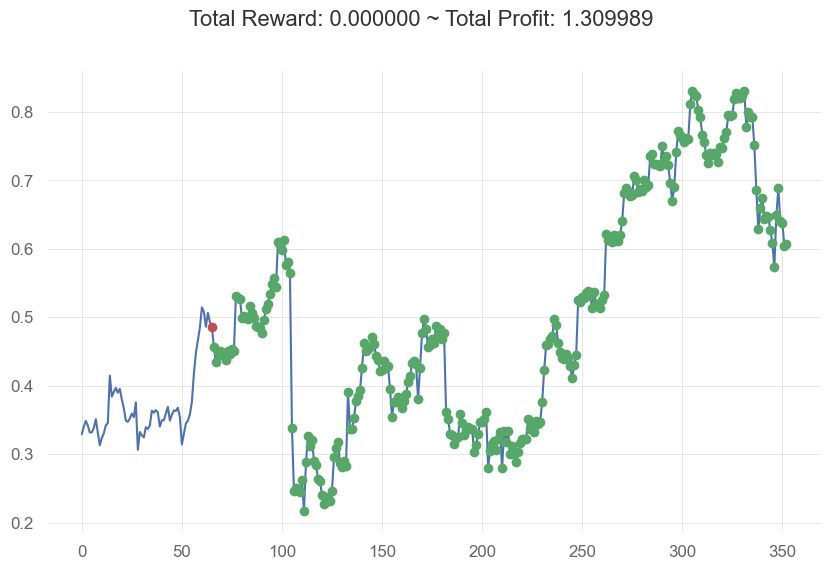

In [105]:
env = MyCustomEnv(df=df, window_size=window_size, frame_bound=(end_train_index, end_val_index))
obs = env.reset()
if isinstance(obs, tuple):  # Handle new gym API
    obs = obs[0]

while True: 
    if obs.ndim == 2:
        obs = obs[np.newaxis, :]  # Add batch dimension if needed
    
    action, _states = model.predict(obs, deterministic=True)
     
    obs, rewards, terminated, truncated, info = env.step(action)  
    done = terminated or truncated
    
    if done:
        print("info", info)
        break
# plt.figure(figsize=(15,6))
# plt.cla()
env.render_all()
plt.show()